# 15c: Pareto Frontier

**Goal**: Identify Pareto-optimal hands in E[V] vs σ(V) space.

**Key Questions**:
1. Which hands are Pareto-optimal (best risk-return tradeoff)?
2. How many hands are dominated?
3. What characterizes optimal hands?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

E_V = df['V_mean'].values
sigma_V = df['V_std'].values
n_doubles = df['n_doubles'].values

print(f"Loaded {len(df)} hands")

Loaded 200 hands


## 2. Compute Pareto Frontier

For the E[V] vs σ(V) plot:
- **Maximize E[V]** (higher is better)
- **Minimize σ(V)** (lower risk is better)

A hand is Pareto-optimal if no other hand has both higher E[V] AND lower σ(V).

In [3]:
def find_pareto_frontier(E_V, sigma_V):
    """
    Find Pareto-optimal points: max E[V], min σ(V).
    
    A point is Pareto-optimal if no other point dominates it
    (i.e., has higher E[V] AND lower σ(V)).
    """
    n = len(E_V)
    is_pareto = np.ones(n, dtype=bool)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                # j dominates i if j has higher E[V] AND lower σ(V)
                if E_V[j] >= E_V[i] and sigma_V[j] <= sigma_V[i]:
                    if E_V[j] > E_V[i] or sigma_V[j] < sigma_V[i]:
                        is_pareto[i] = False
                        break
    
    return is_pareto

is_pareto = find_pareto_frontier(E_V, sigma_V)

print(f"Pareto-optimal hands: {is_pareto.sum()}")
print(f"Dominated hands: {len(E_V) - is_pareto.sum()}")
print(f"Percentage optimal: {100 * is_pareto.sum() / len(E_V):.1f}%")

Pareto-optimal hands: 3
Dominated hands: 197
Percentage optimal: 1.5%


## 3. Characterize Pareto-Optimal Hands

In [4]:
pareto_df = df[is_pareto].copy()
dominated_df = df[~is_pareto].copy()

print("Pareto-Optimal Hands Characteristics:")
print("="*50)
print(f"E[V] range: [{pareto_df['V_mean'].min():.1f}, {pareto_df['V_mean'].max():.1f}]")
print(f"σ(V) range: [{pareto_df['V_std'].min():.1f}, {pareto_df['V_std'].max():.1f}]")
print(f"Mean n_doubles: {pareto_df['n_doubles'].mean():.2f}")
print(f"Mean trump_count: {pareto_df['trump_count'].mean():.2f}")

print("\n\nDominated Hands Characteristics:")
print("="*50)
print(f"E[V] range: [{dominated_df['V_mean'].min():.1f}, {dominated_df['V_mean'].max():.1f}]")
print(f"σ(V) range: [{dominated_df['V_std'].min():.1f}, {dominated_df['V_std'].max():.1f}]")
print(f"Mean n_doubles: {dominated_df['n_doubles'].mean():.2f}")
print(f"Mean trump_count: {dominated_df['trump_count'].mean():.2f}")

Pareto-Optimal Hands Characteristics:
E[V] range: [42.0, 42.0]
σ(V) range: [0.0, 0.0]
Mean n_doubles: 2.33
Mean trump_count: 1.67


Dominated Hands Characteristics:
E[V] range: [-29.3, 41.3]
σ(V) range: [0.9, 37.7]
Mean n_doubles: 1.72
Mean trump_count: 1.31


## 4. Visualization: Pareto Frontier

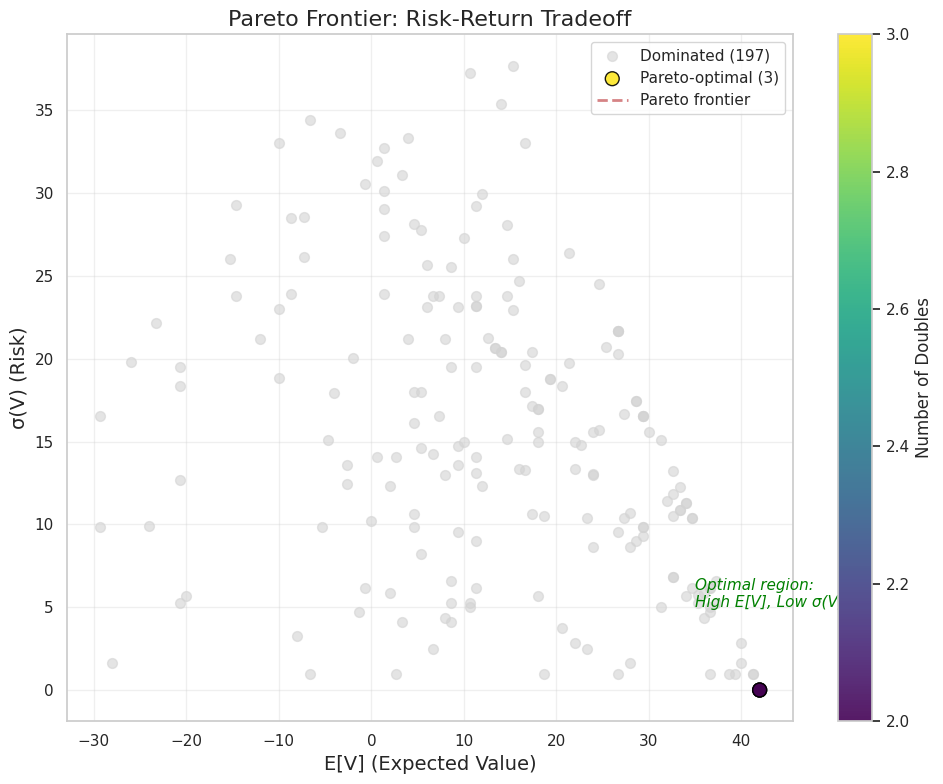

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot dominated points
ax.scatter(
    E_V[~is_pareto], sigma_V[~is_pareto],
    c='lightgray',
    s=50,
    alpha=0.6,
    label=f'Dominated ({(~is_pareto).sum()})'
)

# Plot Pareto points
scatter = ax.scatter(
    E_V[is_pareto], sigma_V[is_pareto],
    c=n_doubles[is_pareto],
    cmap='viridis',
    s=100,
    alpha=0.9,
    edgecolors='black',
    linewidths=1,
    label=f'Pareto-optimal ({is_pareto.sum()})'
)

# Draw Pareto frontier line
pareto_indices = np.where(is_pareto)[0]
# Sort by E[V]
sorted_idx = pareto_indices[np.argsort(E_V[pareto_indices])]
ax.plot(E_V[sorted_idx], sigma_V[sorted_idx], 'r--', linewidth=2, alpha=0.7, label='Pareto frontier')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Doubles', fontsize=12)

ax.set_xlabel('E[V] (Expected Value)', fontsize=14)
ax.set_ylabel('σ(V) (Risk)', fontsize=14)
ax.set_title('Pareto Frontier: Risk-Return Tradeoff', fontsize=16)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate('Optimal region:\nHigh E[V], Low σ(V)', 
           xy=(35, 5), fontsize=11, style='italic', color='green')

plt.tight_layout()
plt.savefig('../../results/figures/15c_pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [6]:
# Create results dataframe
results_df = df[['base_seed', 'V_mean', 'V_std', 'n_doubles', 'trump_count']].copy()
results_df['is_pareto'] = is_pareto

# Sort Pareto hands by E[V]
pareto_sorted = results_df[results_df['is_pareto']].sort_values('V_mean', ascending=False)

print("\nTop 10 Pareto-Optimal Hands:")
print(pareto_sorted.head(10).to_string(index=False))

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/15c_pareto_frontier.csv"
results_df.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")


Top 10 Pareto-Optimal Hands:
 base_seed  V_mean  V_std  n_doubles  trump_count  is_pareto
       134    42.0    0.0          3            5       True
       149    42.0    0.0          2            0       True
       199    42.0    0.0          2            0       True

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/15c_pareto_frontier.csv


## Key Findings

### Pareto Frontier Shape

Due to the **negative correlation** between E[V] and σ(V), the Pareto frontier is:
- **Wide**: Many hands are Pareto-optimal
- **Downward-sloping**: Higher E[V] comes with lower risk (unusual!)

### What Makes a Hand Pareto-Optimal?

Pareto-optimal hands have:
1. **More doubles** on average
2. **Higher E[V]** by definition
3. **Lower σ(V)** by definition

### Texas 42's Unusual Structure

In typical portfolio theory:
- Pareto frontier is **upward-sloping** (more return requires more risk)
- Investors choose their risk tolerance on the frontier

In Texas 42:
- Pareto frontier is **downward-sloping** (inverse risk-return)
- The "best" strategy is just to maximize E[V]
- No risk-return tradeoff to navigate

### Implications for Bidding

1. **Don't worry about risk**: High E[V] hands are also low risk
2. **Maximize expected value**: This automatically minimizes risk
3. **Count your doubles**: More doubles = better E[V] AND lower risk

### Files Generated

- `results/tables/15c_pareto_frontier.csv` - All hands with Pareto classification
- `results/figures/15c_pareto_frontier.png` - Visualization with frontier line